# Clustering analysis of cities

This notebook presents an analysis of cities by different descriptors extracted using a GAN-based method. We explore several ways of assessing similarity between cities based on macro-level remote-sensing data:

* are there patterns in the spatial dependence curves of the gradient across the world? I.e., can we group cities by how the spatial gradient of built areas with population density/luminosity varies across space?

# Packages

In [151]:
import numpy as np
import pandas as pd
import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load city feature data for analysis

In [3]:
checkpoints_path = "/home/data/pytorch-workspace/urban-form-checkpoints/"

#### Data on raw variable and gradient profiles with distance

In [127]:
# load pre-computed profile data

with gzip.open(checkpoints_path + "/profile_stats_85.pickle.gz", "r") as f:
    (dist_pop_mu, dist_pop_se, dist_lum_mu, dist_lum_se, profile_stats) = \
        pickle.load(f)

In [6]:
# load pre-computed gradient data

with gzip.open(checkpoints_path + "/gradient_stats_85.pickle.gz", "r") as f:
    (grad_dist_pop_mu, grad_dist_pop_se, grad_dist_lum_mu, grad_dist_lum_se, scenario_stats) = \
        pickle.load(f)

#### Data on city attributes (for a subset of cities)

#### Visual features extracted from Generator/Discriminator models

In [ ]:
# TODO!

# Cluster cities by spatial profiles

#### Examples of spatial profiles: direct data and gradients

In [38]:
xtick_labels = ((10*200./256)*np.arange(26)).astype(int)

smpl_df = profile_stats.sample(6)
smpl_df

,city,region,pct polycenter
390,"ahmadabad, in (pop 3.7M)",Asia,0.441964
426,"medan, id (pop 1.8M)",Asia,0.397541
621,"szeged, hu (pop 160.6k)",Europe,1.527027
837,"southampton, gb (pop 246.2k)",Europe,0.499208
237,"florence, it (pop 347.2k)",Europe,1.389558
13,"peking, cn (pop 7.5M)",Asia,0.329294


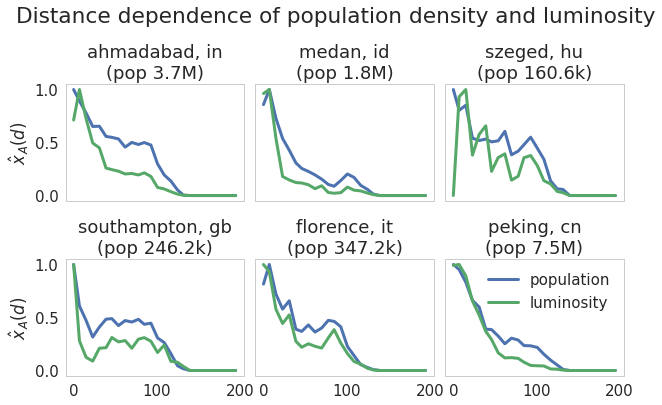

In [45]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), gridspec_kw={"wspace":0.065, "hspace":0.5},
                      sharex=True, sharey=True)

for j,i,a in zip(range(len(smpl_df)), smpl_df.index, ax.flatten()):
    a.plot(xtick_labels, dist_pop_mu[i,:], lw=3, label="population")
    a.plot(xtick_labels, dist_lum_mu[i,:], lw=3, label="luminosity")
    a.set_title(smpl_df.ix[i]['city'].replace(' (','\n('))
    if j % 3 == 0:
        a.set_ylabel("$\hat x_A(d)$")
        
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence of population density and luminosity")

#### Examples of spatial profiles: gradients

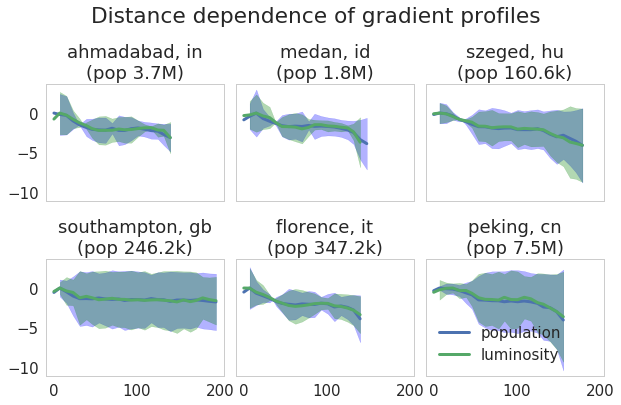

In [50]:
sns.set_context("notebook", font_scale=1.5)
fig, ax = plt.subplots(2,3, figsize=(10,6), gridspec_kw={"wspace":0.065, "hspace":0.5},
                      sharex=True, sharey=True)

for i,a in zip(smpl_df.index, ax.flatten()):
    mu = np.log10(grad_dist_pop_mu[i,:])
    std= np.log10(grad_dist_pop_se[i,:])
    a.plot(xtick_labels, mu, lw=3, label="population")
    a.fill_between(xtick_labels,
                   mu-2*std, 
                   mu+2*std, 
                   color='blue', alpha=0.3)
    mu = np.log10(grad_dist_lum_mu[i,:])
    std= np.log10(grad_dist_lum_se[i,:])
    a.plot(xtick_labels, mu, lw=3, label='luminosity')
    a.fill_between(xtick_labels,
                   mu-2*std, 
                   mu+2*std, 
                   color='green', alpha=0.3)
    if j % 3 == 0:
        a.set_ylabel("$g(d)$")

    a.set_title(smpl_df.ix[i]['city'].replace(' (','\n('))
    
a.legend(loc="best")
fig.subplots_adjust(top=0.8)
plt.suptitle("Distance dependence of gradient profiles")

#### Format data for clustering analysis

In [52]:
idx_ok = ~np.isnan(grad_dist_pop_mu.sum(1))
Xpop = dist_pop_mu[idx_ok,:]
Xlum = dist_lum_mu[idx_ok,:]

Gpop = grad_dist_pop_mu[idx_ok,:]
Gpop = np.log10(Gpop + 1e-6)
Glum = grad_dist_lum_mu[idx_ok,:]
Glum = np.log10(Glum + 1e-6)

#### Find optimum number of clusters via gap statistic

In [53]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
	rng = col.max() - col.min()
	return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=10):
	rng =  range(1, num_iters + 1)
	vals = pd.Series(index=rng)
	for i in rng:
		k = KMeans(n_clusters=n_clusters, n_init=50)
		k.fit(df)
		# print "Ref k: %s" % k.get_params()['n_clusters']
		vals[i] = k.inertia_
	return vals

def gap_statistic(df, max_k=10):
	gaps = pd.Series(index = range(1, max_k + 1))
	for k in range(1, max_k + 1):
		km_act = KMeans(n_clusters=k, n_init=50)
		km_act.fit(df)

		# get ref dataset
		ref = df.apply(get_rand_data)
		ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

		gap = log(ref_inertia - km_act.inertia_)

		# print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
		gaps[k] = gap

	return gaps

In [55]:
# gap statistic analysis to find optimum number of clusters

# population profiles
gaps_pop = gap_statistic(pd.DataFrame(Xpop), max_k=25)
K_pop = np.argmax(gaps_pop)

# luminosity profiles
gaps_lum = gap_statistic(pd.DataFrame(Xlum), max_k=25)
K_lum = np.argmax(gaps_lum)

# population gradient
gaps_g_pop = gap_statistic(pd.DataFrame(Gpop), max_k=25)
K_g_pop = np.argmax(gaps_g_pop)

# luminosity gradient
gaps_g_lum = gap_statistic(pd.DataFrame(Glum), max_k=25)
K_g_lum = np.argmax(gaps_g_lum)

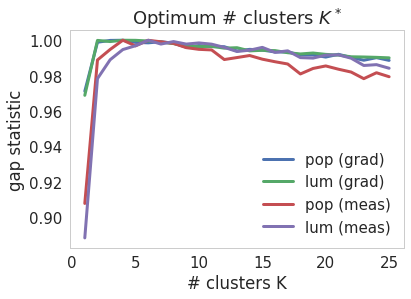

In [59]:
plt.figure(figsize=(6,4))
plt.plot(gaps_g_pop/gaps_g_pop.max(), lw=3, label="pop (grad)")
plt.plot(gaps_g_lum/gaps_g_lum.max(), lw=3, label="lum (grad)")
plt.plot(gaps_pop/gaps_pop.max(), lw=3, label="pop (meas)")
plt.plot(gaps_lum/gaps_lum.max(), lw=3, label="lum (meas)")
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("gap statistic")
plt.legend(loc="best")
plt.show()


In [60]:
K_pop, K_lum, K_g_pop, K_g_lum

(4, 6, 4, 4)

#### Cluster profiles and plot cluster centers

In [86]:
def clustering_analysis(X, text, K=4, nrow=1, figsize=(10,3)):
    
    # k-means clustering
    
    kmeans_mod = KMeans(n_clusters=K, n_init=100)
    C = kmeans_mod.fit_predict(X).astype(int)
    centroids = kmeans_mod.cluster_centers_

    clust_sizes = pd.Series(C).value_counts()
    plt.figure(figsize=(6,4))
    ax = clust_sizes.plot(kind="bar")
    ax.set_title("Cluster size: %s"%text, fontsize=20)
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("count")
    plt.show()
    
    nx = nrow
    ny = K / nx

    xtick_labels = ((10*200./256)*np.arange(26)).astype(int)

    fig, ax = plt.subplots(nx,ny, gridspec_kw={"wspace":0.045, "hspace":0.5},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k in range(K):
        a = ax[k%nx,k/nx]
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        a.plot(xtick_labels, centroids[k,:], lw=3, color='k')
        a.fill_between(xtick_labels,
                       centroids[k,:]-2*std, 
                       centroids[k,:]+2*std, 
                       color='red', alpha=0.3)
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k % nx == 0:
            a.set_xlabel("d [km]")
            a.set_xticks(xtick_labels[::6])
            a.set_xticklabels(xtick_labels[::6], rotation=30)

    plt.suptitle("Clustering cities by %s"%text, )
    fig.subplots_adjust(top=0.75)
    plt.show()
    
    return C, centroids

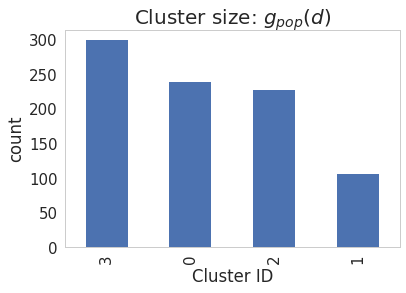

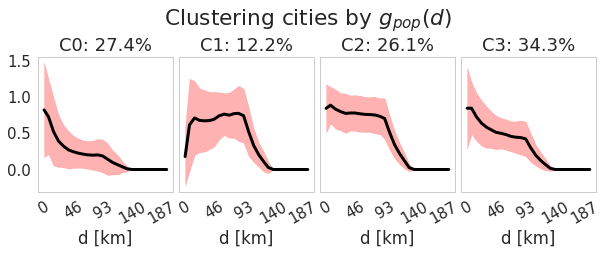

In [87]:
C_pop, cntr_pop = clustering_analysis(Xpop, "$g_{%s}(d)$"%"pop", 
                                      K=K_pop, nrow=1)

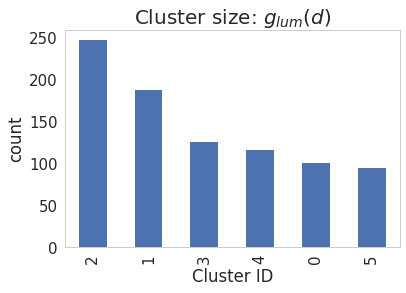

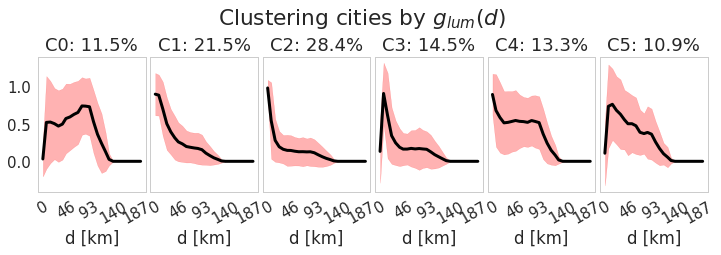

In [88]:
C_lum, cntr_lum = clustering_analysis(Xlum, "$g_{%s}(d)$"%"lum", 
                                      K=K_lum, nrow=1, figsize=(12,3))

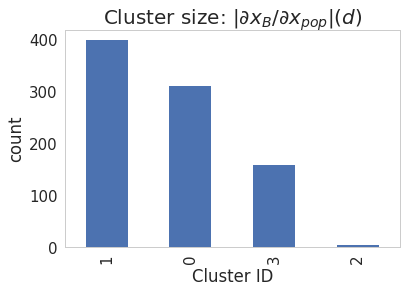

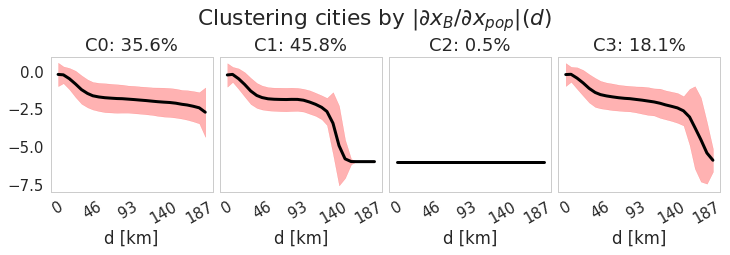

In [89]:
C_g_pop, cntr_g_pop = clustering_analysis(Gpop, 
                                        "$|\partial x_B/\partial x_{%s}|(d)$"%"pop", 
                                        K=K_g_pop, nrow=1, figsize=(12,3))

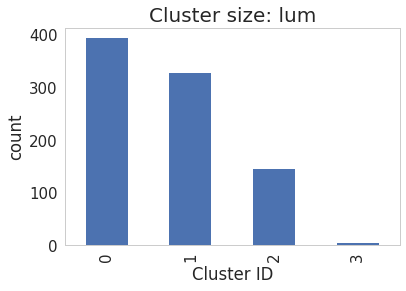

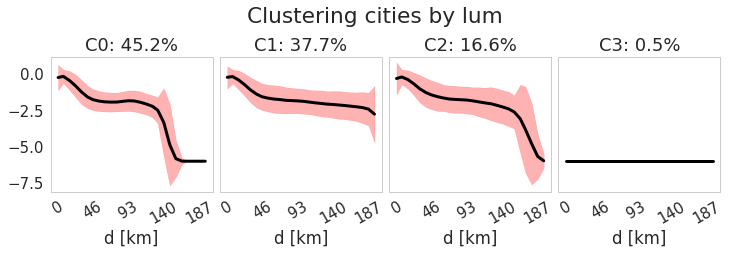

In [90]:
C_g_lum, cntr_g_lum = clustering_analysis(Glum, "lum", 
                                          K=K_g_lum, nrow=1, 
                                          figsize=(12,3))

#### Combine luminosity & population clusters

In [91]:
clust_cross = (pd.crosstab(C_lum, C_pop).astype(float) / len(C_pop) * 100).round(1)

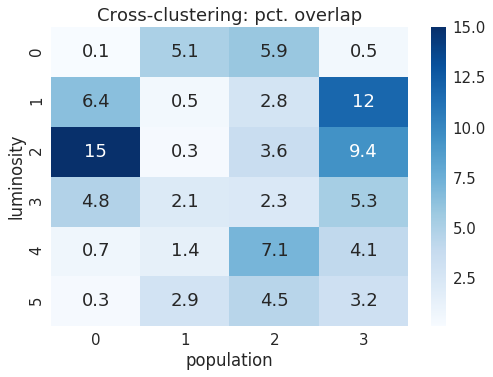

In [92]:
ax = sns.heatmap(clust_cross, annot=True, cmap="Blues")
plt.ylabel("luminosity")
plt.xlabel("population")
plt.title("Cross-clustering: pct. overlap")

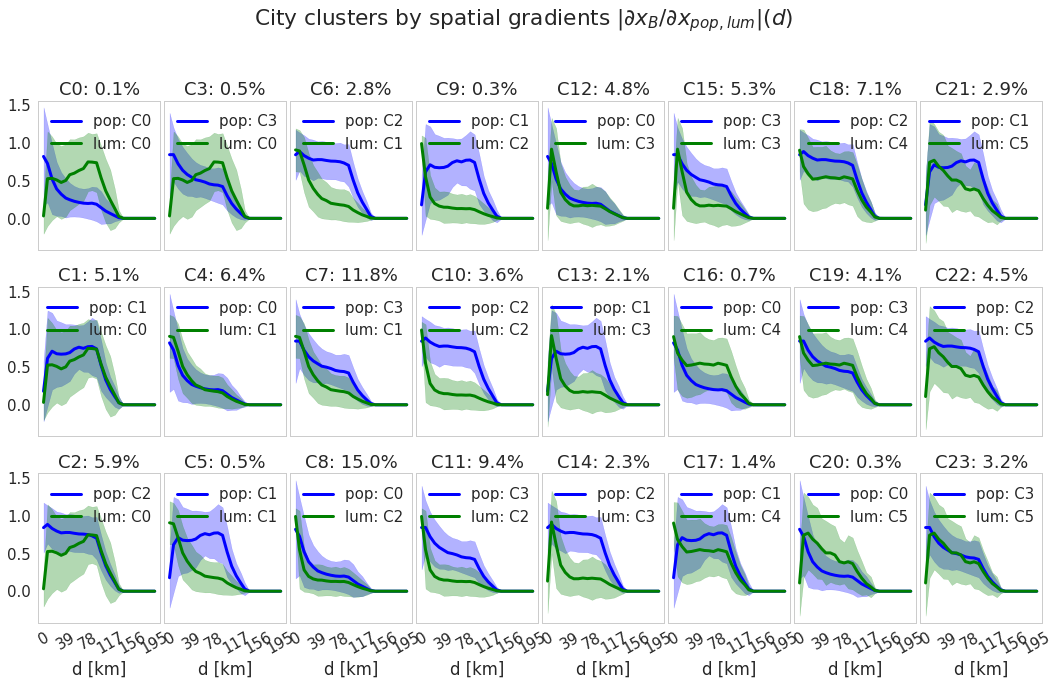

In [96]:
k_lum, k_pop = np.where(clust_cross)

nx = 3
ny = len(k_pop) / nx

fig, ax = plt.subplots(nx,ny, gridspec_kw={"wspace":0.03, "hspace":0.25},
                       figsize=(18,10), sharex=True, sharey=True)

for k,(kp,kl) in enumerate(zip(k_pop, k_lum)):
    a = ax[k%nx,k/nx]
    # plot population centroid
    idx_pop = np.where(C_pop == kp)[0]
    std = Xpop[idx_pop,:].std(0)
    a.plot(xtick_labels, cntr_pop[kp,:], lw=3, color='b', label="pop: C%d"%kp)
    a.fill_between(xtick_labels,
                   cntr_pop[kp,:]-2*std, 
                   cntr_pop[kp,:]+2*std, 
                   color='b', alpha=0.3)
    # plot luminosity centroid
    idx_lum = np.where(C_lum == kl)[0]
    std = Xlum[idx_lum,:].std(0)
    a.plot(xtick_labels, cntr_lum[kl,:], lw=3, color='g', label="lum: C%d"%kl)
    a.fill_between(xtick_labels,
                   cntr_lum[kl,:]-2*std, 
                   cntr_lum[kl,:]+2*std, 
                   color='g', alpha=0.3)
    # a.axis("off")
    a.set_title("C%d: %2.1f%%"%(k,clust_cross.ix[kl,kp]))
    if (k+1) % nx == 0:
        a.set_xlabel("d [km]")
        a.set_xticks(xtick_labels[::5])
        a.set_xticklabels(xtick_labels[::5], rotation=30)
    a.legend(loc="best")
        
plt.suptitle("City clusters by spatial gradients $|\partial x_B/\partial x_{pop,lum}|(d)$")
fig.subplots_adjust(top=0.85)
plt.show()


# Relate clusters to macroeconomic data on cities

In this section, we analyze the relationship between several macroeconomic indicators measured at the level of cities to the classes of urban form that the city belongs to. We use a discrete-choice modeling approach, where the dependent variable is the city class (as inferred from one of the GAN-based models), and the independent variables (covariates) are the macroeconomic indicators. 

In [284]:
attributes_df = pd.read_csv("/home/data/workspace/urban-form/cities_macroeconomic_data.csv")
attributes_df['city'] = attributes_df['city'].apply(\
                                        lambda x: re.sub(r' \([^)]*\)', '', x))
attributes_df = attributes_df.fillna(attributes_df.mean())
attributes_df.set_index("city", inplace=True)

print attributes_df.shape

(310, 36)


In [298]:
profile_stats['city name'] = profile_stats.city.apply(lambda x: 
            x.split(",")[0] + ", " + x.split(",")[1].split(" ")[1])
profile_stats['city name'] = profile_stats['city name'].apply(\
                                        lambda x: re.sub(r' \([^)]*\)', '', x))
profile_stats.set_index("city name", inplace=True)
profile_stats['clust grad pop'] = C_g_pop
profile_stats['clust grad lum'] = C_g_lum
profile_stats['clust grad'] = profile_stats['clust grad lum'].astype(str) + profile_stats['clust grad pop'].astype(str)
profile_stats['clust pop'] = C_pop
profile_stats['clust lum'] = C_lum
profile_stats['clust'] = profile_stats['clust lum'].astype(str) + profile_stats['clust pop'].astype(str)

print profile_stats.shape

(871, 9)


In [299]:
data_df = attributes_df.join(profile_stats)
data_df.dropna(inplace=True)
train_cols = attributes_df.columns
resp_col = "clust pop"

print data_df.shape

(126, 45)


In [300]:
import statsmodels.api as st

X = data_df[train_cols].values
X = (X - X.mean(0)) / (X.std(0) + 1e-6)

X = np.hstack([X, np.ones((len(X),1))])

y = data_df[resp_col].astype(str).values
mnl = st.MNLogit(y, X)
mnl_fit = mnl.fit_regularized(alpha=1)
mnl_stats = mnl_fit.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.82583703201
            Iterations: 269
            Function evaluations: 269
            Gradient evaluations: 269


LinAlgError: Singular matrix

In [293]:
signif_vars_df = pd.DataFrame(mnl_fit.pvalues, index=train_cols.values.tolist() + ['intercept'])

In [294]:
idx_ok = (~signif_vars_df[signif_vars_df<0.05].isnull()).sum(1)>0
signif_vars_df[idx_ok]

,0,1,2,3
FRAGMENTATION_ADM,0.036012,0.912137,NaN,NaN
LOC_GOV_CORE_ADM,0.016382,NaN,0.879728,0.567966
GDP_PC_GDP,0.977739,0.140678,0.033650,NaN
intercept,0.139940,0.000291,0.000104,0.000238


In [283]:
mnl_stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                        MNLogit   Df Residuals:                       70
Method:                           MLE   Df Model:                           54
Date:                Thu, 13 Jul 2017   Pseudo R-squ.:                  0.4564
Time:                        23:25:16   Log-Likelihood:                -49.890
converged:                       True   LL-Null:                       -91.771
                                        LLR p-value:                  0.005824
==============================================================================
     y=1.0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7469      1.546      1.130      0.259      -1.284       4.777
x2            -0.0321      0.624     -0.051      0.959      -1.254       1.190
x3            -0.5633      0.729     -0.773      0.440      -1.992       0.865
x4            -0.1175        nan        nan        nan         nan         nan
x5             2.2977      1.571      1.462      0.144      -0.782       5.377
x6             0.4892      1.120      0.437      0.662      -1.707       2.685
x7                  0        nan        nan        nan         nan         nan
x8             0.3473      0.521      0.666      0.505      -0.675       1.369
x9             1.3606      1.407      0.967      0.334      -1.397       4.119
x10           -0.0335      1.137     -0.029      0.976      -2.261       2.194
x11           -0.2957      0.880     -0.336      0.737      -2.020       1.429
x12            0.7794      4.656      0.167      0.867      -8.345       9.904
x13                 0        nan        nan        nan         nan         nan
x14            1.4085      1.733      0.813      0.416      -1.988       4.805
x15           -0.1919      1.395     -0.138      0.891      -2.927       2.543
x16            0.0899      1.038      0.087      0.931      -1.944       2.124
x17            0.5713   3.47e+07   1.65e-08      1.000    -6.8e+07     6.8e+07
x18           -0.8559        nan        nan        nan         nan         nan
x19                 0        nan        nan        nan         nan         nan
x20           -5.1318      4.853     -1.057      0.290     -14.643       4.380
x21            1.3389      5.782      0.232      0.817      -9.993      12.671
x22            0.5577      2.343      0.238      0.812      -4.033       5.149
x23           -0.3110      4.884     -0.064      0.949      -9.884       9.262
x24                 0        nan        nan        nan         nan         nan
x25            1.3184      9.212      0.143      0.886     -16.737      19.373
x26            3.1736      2.775      1.144      0.253      -2.265       8.612
x27                 0        nan        nan        nan         nan         nan
x28                 0        nan        nan        nan         nan         nan
x29           -0.7399      5.956     -0.124      0.901     -12.414      10.935
x30                 0        nan        nan        nan         nan         nan
x31            1.1344      3.321      0.342      0.733      -5.374       7.643
x32           -3.0077      1.831     -1.642      0.101      -6.597       0.582
x33            0.5713   2.67e+07   2.14e-08      1.000   -5.24e+07    5.24e+07
x34           -0.8559        nan        nan        nan         nan         nan
x35                 0        nan        nan        nan         nan         nan
x36           -0.1175        nan        nan        nan         nan         nan
const          2.8444      0.723      3.935      0.000       1.428       4.261
------------------------------------------------------------------------------
  